In [ ]:
!pip install gdown
!gdown --id 1If5gkWEfChJHc8v8CCEhGhEeeAqsxKTz

In [5]:
import math
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.models import UNet

device = 'cuda'

# define small pretrained unet

net = UNet(
    input_channels=1,
    input_height=28,
    ch=32,
    ch_mult=(1, 2),
    num_res_blocks=2,
    attn_resolutions=(16,),
    resamp_with_conv=True,
).to(device)

net.load_state_dict(torch.load('model_final_mnist_dirichlet.pt'))
net.eval()

# load testset and define latent distribution
transform = transforms.Compose([transforms.ToTensor()])
diri = torch.distributions.Dirichlet(torch.ones(784))
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def upsample(x, sf=4):
    '''s-fold upsampler

    Upsampling the spatial size by filling the new entries with zeros

    x: tensor image, NxCxWxH
    '''
    st = 0
    z = torch.zeros(
        (x.shape[0],
         x.shape[1],
         x.shape[2] *
         sf,
         x.shape[3] *
         sf)).type_as(x)
    z[..., st::sf, st::sf].copy_(x)
    return z

def upsample_bicubic(x, sf=2):
    '''s-fold upsampler

    Upsampling the spatial size by filling the new entries with zeros

    x: tensor image, NxCxWxH
    '''
    st = 0
    z = torch.zeros(
        (x.shape[0],
         x.shape[1],
         x.shape[2] *
         sf,
         x.shape[3] *
         sf)).type_as(x)
    z[..., st::sf, st::sf].copy_(x)
    z = F.interpolate(z, scale_factor=sf, mode='bicubic')
    return z


def downsample(x, sf=2):
    '''s-fold downsampler

    Keeping the upper-left pixel for each distinct sfxsf patch and discarding the others

    x: tensor image, NxCxWxH
    '''
    st = 0
    return x[..., st::sf, st::sf]


tensor([1.0029, 1.0038, 1.0057, 1.0083, 1.0064, 1.0081, 1.0015, 1.0142, 1.0032,
        0.9993, 0.9930, 1.0051, 1.0008, 1.0120, 0.9934, 1.0024],
       device='cuda:0', grad_fn=<SumBackward1>)


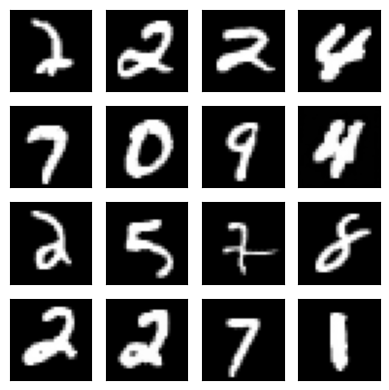

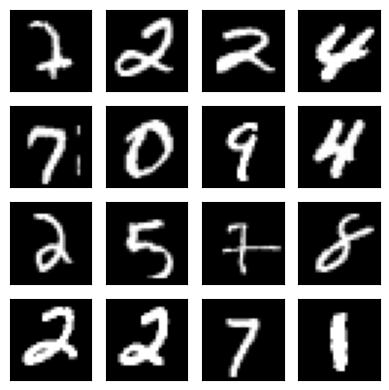

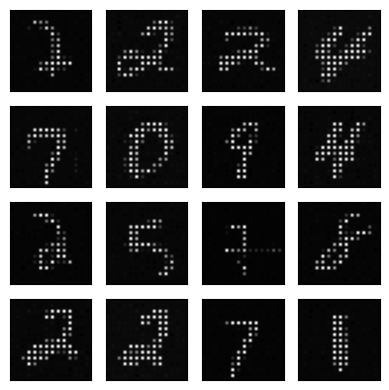

tensor(0.0012, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0064, device='cuda:0')


In [6]:
## Superresolution Experiment

# load batch and normalize it to the simplex
torch.manual_seed(0)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                          shuffle=True, num_workers=1)

batch,y  = next(iter(testloader))
batch = batch.to(device)
batch = batch/torch.sum(batch, dim = (1,2,3)).unsqueeze(1).unsqueeze(1).unsqueeze(1)


batch_y = batch.clone().to(device)
batch_y = downsample(batch_y, sf = 2) + torch.randn_like(downsample(batch_y, sf = 2))*0.0001

x = diri.sample([16]).to(device)
x = x.view(16,1,28,28)

steps = 300
num_samples = 5

for k in range(steps):
    t = k/steps
    time = torch.tensor(t).to(device)
    x.requires_grad_()
    datafit = torch.sum((downsample(x, sf = 2)-batch_y)**2)*0.5
    grad = torch.autograd.grad(datafit, x)[0]
    x = x.detach()
    z = x - ((1-t))*grad
    x_new = 0
    for _ in range(num_samples):
        z2 = diri.sample([x.shape[0]]).to(device)
        z2 = z2.view(x.shape[0],1,28,28)
        z_new = t*z+(1-t)*z2
        x_new += z_new + (1-t)*net(z_new,time.repeat(x.shape[0]))
    x = x_new/num_samples

print(torch.sum(x, dim = (1,2,3)))
f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(x.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("reco.png")
plt.show()

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(batch.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("groundtruth.png")
plt.show()


f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(upsample(batch_y, sf = 2).cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("measurements.png")
plt.show()

print(torch.sum((batch-x)**2)/len(batch))
print(torch.sum((batch-upsample(batch_y, sf = 2))**2)/len(batch))

tensor([0.9834, 0.9911, 0.9815, 0.9978, 1.0165, 1.0037, 0.9867, 0.9911, 0.9812,
        0.9996, 0.9792, 0.9715, 0.9786, 0.9880, 1.0009, 1.0006],
       device='cuda:0', grad_fn=<SumBackward1>)


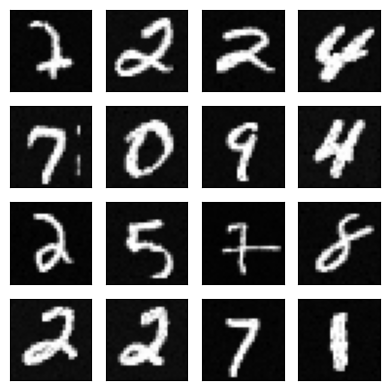

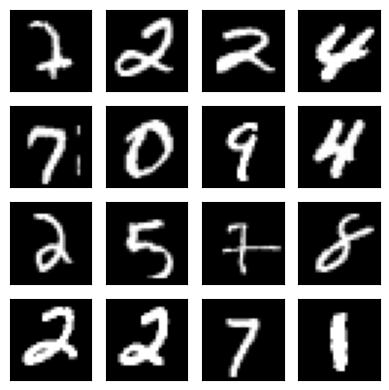

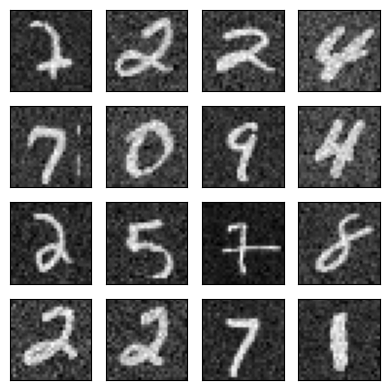

tensor(9.4591e-05, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0008, device='cuda:0')


In [4]:
## Denoising Experiment

batch_y = batch.clone().to(device)
torch.manual_seed(1)
batch_y = batch_y+ torch.randn_like(batch_y)*0.001

x = diri.sample([16]).to(device)
x = x.view(16,1,28,28)

steps = 300
num_samples = 5

for k in range(steps):
    t = k/steps
    time = torch.tensor(t).to(device)
    x.requires_grad_()
    datafit = torch.sum((x-batch_y)**2)*0.5
    grad = torch.autograd.grad(datafit, x)[0]
    x = x.detach()
    z = x - ((1-t))*grad
    x_new = 0
    for _ in range(num_samples):
        z2 = diri.sample([x.shape[0]]).to(device)
        z2 = z2.view(x.shape[0],1,28,28)
        z_new = t*z+(1-t)*z2
        x_new += z_new + (1-t)*net(z_new,time.repeat(x.shape[0]))
    x = x_new/num_samples

print(torch.sum(x, dim = (1,2,3)))

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(x.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("reco_den.png")
plt.show()

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(batch.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("groundtruth_den.png")
plt.show()


f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(batch_y.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("measurements_den.png")
plt.show()

print(torch.sum((batch-x)**2)/len(batch))
print(torch.sum((batch-batch_y)**2)/len(batch))

tensor([1.0125, 1.0154, 1.0126, 1.0207, 1.0196, 1.0237, 1.0063, 1.0173, 1.0051,
        1.0139, 1.0160, 1.0077, 1.0134, 1.0182, 1.0070, 1.0004],
       device='cuda:0', grad_fn=<SumBackward1>)


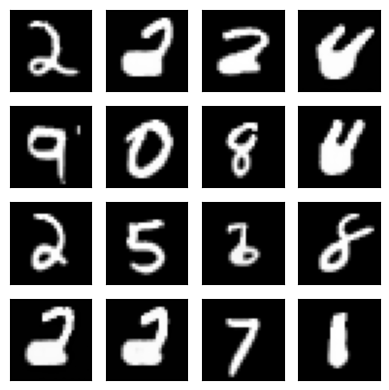

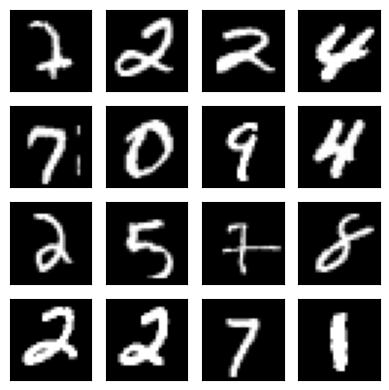

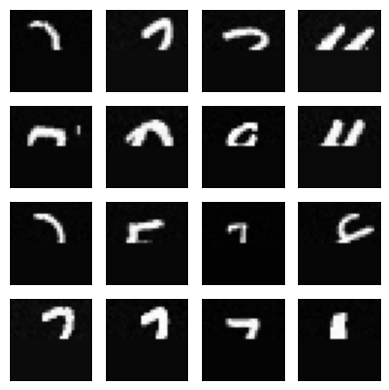

tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0049, device='cuda:0')


In [7]:
## Inpainting Experiment

batch_y = batch.clone().to(device)
torch.manual_seed(2)
batch_y = batch_y[:,:,:14,:] + torch.randn_like(batch_y[:,:,:14,:])*0.0001

x = diri.sample([16]).to(device)
x = x.view(16,1,28,28)

steps = 300
num_samples = 5

for k in range(steps):
    t = k/steps
    time = torch.tensor(t).to(device)
    x.requires_grad_()
    datafit = torch.sum((x[:,:,:14,:]-batch_y)**2)*0.5
    grad = torch.autograd.grad(datafit, x)[0]
    x = x.detach()
    z = x - ((1-t))*grad
    x_new = 0
    for _ in range(num_samples):
        z2 = diri.sample([x.shape[0]]).to(device)
        z2 = z2.view(x.shape[0],1,28,28)
        z_new = t*z+(1-t)*z2
        x_new += z_new + (1-t)*net(z_new,time.repeat(x.shape[0]))
    x = x_new/num_samples

print(torch.sum(x, dim = (1,2,3)))

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(x.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()

#plt.savefig("reco_inp.png")
plt.show()

f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(batch.cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("groundtruth_inp.png")
plt.show()


f, axarr = plt.subplots(4,4, figsize = (4,4))
for k in range(4):
    for l in range(4):
        axarr[k,l].imshow(torch.cat((batch_y, torch.zeros_like(batch_y)),2).cpu().data.numpy()[k*4+l].reshape(28,28), cmap = 'gray')
        axarr[k,l].get_yaxis().set_ticks([])
        axarr[k,l].get_xaxis().set_ticks([])
plt.tight_layout()
#plt.savefig("measurements_inp.png")
plt.show()

print(torch.sum((batch-x)**2)/len(batch))
print(torch.sum((batch-torch.cat((batch_y,torch.zeros_like(batch_y)),2))**2)/len(batch))